In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trackbact as tb

# Load the data

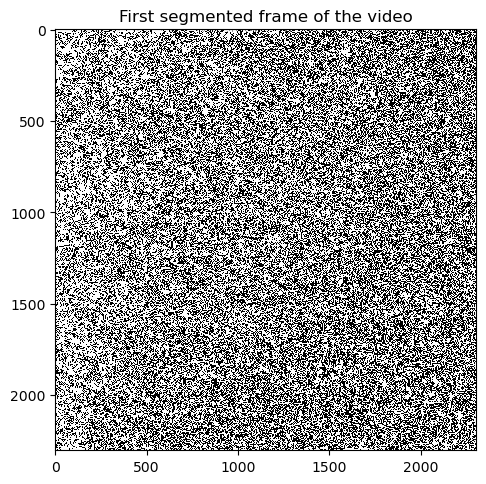

2304 2304


In [51]:
file_name="WT_dense_segmented.tif"
im=tb.load_tif(file_name, show=True)
tifdim1=im.shape[1]
tifdim2=im.shape[2]
print(tifdim1, tifdim2)

# Fit ellipses to the contours

In [ ]:
fitted_ellipses=tb.fit_ellipses(im, show_nth_frame=10, filter_max=(6,60))

Finding the contours of the bacteria...:  26%|██████████▌                             | 53/201 [00:13<00:31,  4.75it/s]

# Format the data and plot the distribution of alignment angles

In [ ]:
#format the fitted ellipses into a dataframe for tracking
ellipses_df=tb.format_ellipses(fitted_ellipses)
display(ellipses_df)

#For PIV analysis: Uncomment below to transform ellipses into single points
#tb.ellipse_to_particle(im, file_name, ellipses_df)


plt.hist(ellipses_df["body_angle"], bins=59, histtype='bar', ec='white')
plt.title("Orientation distribution of alignment angles")
plt.xlabel('Angle [degrees]')
plt.ylabel('Count of detected particles [-]')
plt.show()

# Count the number of particles per frame
particles_per_frame = ellipses_df.groupby('frame').size()

# Calculate the mean number of particles across all frames
mean_particles = particles_per_frame.mean()

# Plotting the number of detected particles per frame
plt.figure(figsize=(10,6))
plt.plot(particles_per_frame.index, particles_per_frame.values, marker='o', label='Detected particles per frame')  # Use plt.bar for a bar chart

# Plotting the mean number of particles as a horizontal line
plt.axhline(y=mean_particles, color='r', linestyle='-', label=f'Mean particles (avg: {mean_particles:.2f})')

# Adding titles and labels
plt.title('Number of detected particles per frame')
plt.xlabel('Frame Number [-]')
plt.ylabel('Count of detected particles [-]')
plt.grid(True)
plt.legend()  # Show legend
plt.show()

In [ ]:
import trackpy.diag
trackpy.diag.performance_report()

# Track the bacteria and write the results to disk

In [ ]:
traj_tp = tb.track_bacteria(ellipses_df, max_search_range=10, min_search_range=2, filter=30)
display(traj_tp)
tb.write_trajectory(traj_tp, file_name)

# Load the results of the tracking

In [ ]:
traj_loaded=tb.read_trajectory(file_name)
display(traj_loaded)

# Plot trajectories

In [ ]:
tb.plot_traj_all(traj_loaded, imdim1=tifdim1, imdim2=tifdim2, pix_size=0.1625)

# Calculate the kinematic parameters such as velocity and acceleration etc.

In [ ]:
particle_params=tb.calculate_kinematic_parameters(traj_tp, time_step=1)

particle_params.rename(columns={"x": "x [um]","y": "y [um]","major_axis_size": "major_axis_size [um]","minor_axis_size": "minor_axis_size [um]", "body_angle": "body_angle [degrees]", "vx":"vx [um/s]", "vy":"vy [um/s]", "vel":"vel [um/s]", "ax":"ax [um/s^2]", "ay":"ay [um/s^2]", "acc":"acc [um/s^2]", "diff_body_angle":"diff_body_angle [degrees]", "angular_vel": "angular_vel [degrees/s]", "angular_acc": "angular_acc [degrees/s^2]"}, inplace=True)

display(particle_params)


tb.write_kinematics(particle_params, file_name)

# Data analysis

In [ ]:
#To quantify reversal

df = particle_params

# Calculate the sign of velocities
df['vx_sign'] = df['vx'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df['vy_sign'] = df['vy'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Function to count reversals in a group
def count_reversals(group):
    group['vx_sign_change'] = group['vx_sign'].diff() != 0
    group['vy_sign_change'] = group['vy_sign'].diff() != 0
    group['reversal'] = (group['vx_sign_change'] & group['vy_sign_change']).astype(int)
    return group['reversal'].sum()

# Apply the function to each group and get the count of reversals per particle
reversals_per_particle = df.groupby('particle').apply(count_reversals)

# Convert to DataFrame for better readability and add an index
reversals_df = reversals_per_particle.reset_index()
reversals_df.columns = ['Particle', 'Reversals']
reversals_df.index.name = 'Index'

# Calculate average and standard deviation
average_reversals = reversals_df['Reversals'].mean()
std_dev_reversals = reversals_df['Reversals'].std()

print("Indexation of Groups (Particles) and Their Reversals:")
print(reversals_df)
print(f"\nTotal number of unique particles: {len(reversals_df)}")
print(f"\nAverage number of reversals: {average_reversals}")
print(f"Standard deviation of reversals: {std_dev_reversals}")